In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from model import GPT
from evals import grammar_evals
from dgp import get_dataloader
import os
import pickle as pkl
import json
from sae import SAEData, SAE
import matplotlib.pyplot as plt
import random
import seaborn as sns
import matplotlib
import math
from math import ceil
import umap.umap_ as um
import umap.plot
from tqdm import tqdm

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/lib/python3.11/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Load Model, Config, Data

In [2]:
path = 'results/scratch/12owob2t' #['12owob2t', '3v4gwdfk', 'cpyib3ss']
state_dict = torch.load(os.path.join(path, 'latest_ckpt.pt'), map_location='cpu')
cfg = state_dict['config']

In [3]:
with open(os.path.join(path, 'grammar/PCFG.pkl'), 'rb') as f:
    pcfg = pkl.load(f)
model = GPT(cfg.model, pcfg.vocab_size)
model.load_state_dict(state_dict['net'])
model.eval()
dataloader = get_dataloader(
        language=cfg.data.language,
        config=cfg.data.config,
        alpha=cfg.data.alpha,
        prior_type=cfg.data.prior_type,
        num_iters=cfg.data.num_iters * cfg.data.batch_size,
        max_sample_length=cfg.data.max_sample_length,
        seed=cfg.seed,
        batch_size=cfg.data.batch_size,
        num_workers=0,
    )

In [4]:
layer_name = 'res0'
data = SAEData(model_dir=path, ckpt='latest_ckpt.pt', layer_name=layer_name, config=False, device='cpu')
match layer_name:
    case "wte":   module = model.transformer.wte
    case "wpe":   module = model.transformer.wpe
    case "attn0": module = model.transformer.h[0].attn
    case "mlp0":  module = model.transformer.h[0].mlp
    case "res0":  module = model.transformer.h[0]
    case "attn1": module = model.transformer.h[1].attn
    case "mlp1":  module = model.transformer.h[1].mlp
    case "res1":  module = model.transformer.h[1]
    case "ln_f":  module = model.transformer.ln_f

Loading model...
Model loaded.


# Analysing Trained SAEs

In [5]:
def get_sae(idx):
    embedding_size = data[0][0].size(-1)
    args = json.load(open(os.path.join(path, f'sae_{idx}/config.json')))
    sae = SAE(embedding_size, args['exp_factor'] * embedding_size, pre_bias=args['pre_bias'], k=args['k'], sparsemax=args['sparsemax'] if 'sparsemax' in args.keys() else False, norm=args['norm'])
    state_dict = torch.load(os.path.join(path, f'sae_{idx}/model.pth'), map_location='cpu')
    sae.load_state_dict(state_dict)
    sae.eval()
    return sae

def get_config(idx):
    return json.load(open(os.path.join(path, F'sae_{idx}/config.json')))

## Examining Features

What is the distribution of latent features?

In [6]:
def get_latents_and_sequences(sae, num_sequences=128):
    latents = []
    sequences = []
    dec = dataloader.dataset.decorator_length
    pcfg = dataloader.dataset.PCFG
    pad = pcfg.vocab['<pad>']
    eos = pcfg.vocab['<eos>']

    for _ in range(num_sequences):
        activn, grad, seq = data[0]
        latent, _ = sae(activn)
        latents.append(latent.detach())
        sequences.append([c for c in seq.tolist() if c not in [pad, eos]][dec:])

    latents = torch.cat(latents, dim=0)
    return latents, sequences


(array([1.07592e+05, 1.35000e+02, 3.19000e+02, 2.24900e+03, 2.94600e+03,
        9.17000e+02, 2.52000e+02, 1.50000e+01, 1.00000e+00, 6.00000e+00]),
 array([   0.        ,  544.75939941, 1089.51879883, 1634.27832031,
        2179.03759766, 2723.79711914, 3268.55664062, 3813.31591797,
        4358.07519531, 4902.83496094, 5447.59423828]),
 <BarContainer object of 10 artists>)

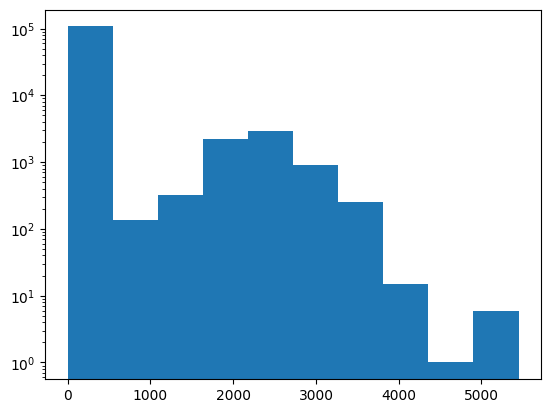

In [7]:
sae = get_sae(21)
latents, sequences = get_latents_and_sequences(sae, num_sequences=128)
plt.yscale('log')
plt.hist(latents.flatten().numpy(), bins=10)

In [8]:
# Sparsity
print(((latents == 0).sum(dim=0) == latents.size(0)).sum())
print(latents.size(1))

tensor(219)
256


### Token-wise Activations
What tokens do the features activate on?

In [9]:
latents_by_sequence = []
temp = latents.clone()
for sequence in sequences:
    latents_by_sequence.append(temp[:len(sequence)])
    temp = temp[len(sequence):]

In [10]:
def get_depths(tokens, pcfg, retain_all=False):
    """
    Returns the depth of the token at idx in the sentence.
    If retain_all is True, we return the depths of intermediate nonterminals also (along with the string).
    """
    parsed = str(next(pcfg.parser.parse(tokens))).split()[:-1]
    token_indices = []
    idx = 0
    for i, p in enumerate(parsed):
        if p.replace('(', '').replace(')', '') == tokens[idx]:
            token_indices.append(i)
            idx += 1
        if idx == len(tokens): break
    c = 0
    depths = []
    for i, p in enumerate(parsed):
        if i in token_indices or retain_all:
            depths.append(c)
        c += p.count('(') - p.count(')')
    if retain_all:
        return depths, [p.replace('(', '').replace(')', '') for p in parsed], token_indices
    return depths

In [11]:
def plot_latents_linearly(tokens, latents, vmax, vmin, heatmap=False):
    plt.figure(figsize = (len(sequences[i])*0.7, 0.4))

    if heatmap:
        sns.heatmap(latents.unsqueeze(0),
                    annot=[tokens],
                    fmt='', linewidths=.5, vmax=vmax, vmin=vmin, cmap='rocket', xticklabels=False, yticklabels=False)
    else:
        plt.plot(latents.numpy(), marker='o')
        plt.xticks(range(len(tokens)), tokens)
        plt.ylim(vmin-((vmax-vmin)/50), vmax)

    plt.show()

def plot_latents_by_depth(tokens, latents, pcfg, vmax, vmin):
    depths = get_depths(tokens, pcfg)
    depths = [ceil(d / 2) - 2 for d in depths] # for 12owob2t

    depth_hm = torch.zeros(len(tokens), max(depths)+1)
    annot = [['' for _ in range(max(depths)+1)] for _ in range(len(tokens))]
    for i, d in enumerate(depths):
        annot[i][d] = tokens[i]
        depth_hm[i, d] = latents[i].item()

    plt.figure(figsize = ((max(depths)+1)*0.9, len(tokens)*0.4))
    sns.heatmap(depth_hm, annot=annot, fmt='', linewidths=.5, vmax=vmax, vmin=vmin, cmap='rocket', xticklabels=range(1, max(depths)+2), yticklabels=range(1, len(tokens)+1))
    plt.show()

def plot_latents_by_pending(tokens, latents, vmax, vmin):
    pending = 1
    pending_by_token = []
    for token in tokens:
        match token[:-1]:
            case 'dig': pending -= 1
            case 'un': pending += 0
            case 'bin': pending += 1
            case 'tern': pending += 2
        pending_by_token.append(pending)
    assert pending_by_token[-1] == 0

    pending_hm = torch.zeros(len(tokens), max(pending_by_token)+1)
    annot = [['' for _ in range(max(pending_by_token)+1)] for _ in range(len(tokens))]
    for i, p in enumerate(pending_by_token):
        pending_hm[i, p] = latents[i].item()
        annot[i][p] = tokens[i]
    
    plt.figure(figsize = ((max(pending_by_token)+1)*0.9, len(tokens)*0.4))
    sns.heatmap(pending_hm, annot=annot, fmt='', linewidths=.5, vmax=vmax, vmin=vmin, cmap='rocket', xticklabels=range(max(pending_by_token)+1), yticklabels=range(1, len(tokens)+1))
    plt.show()

164


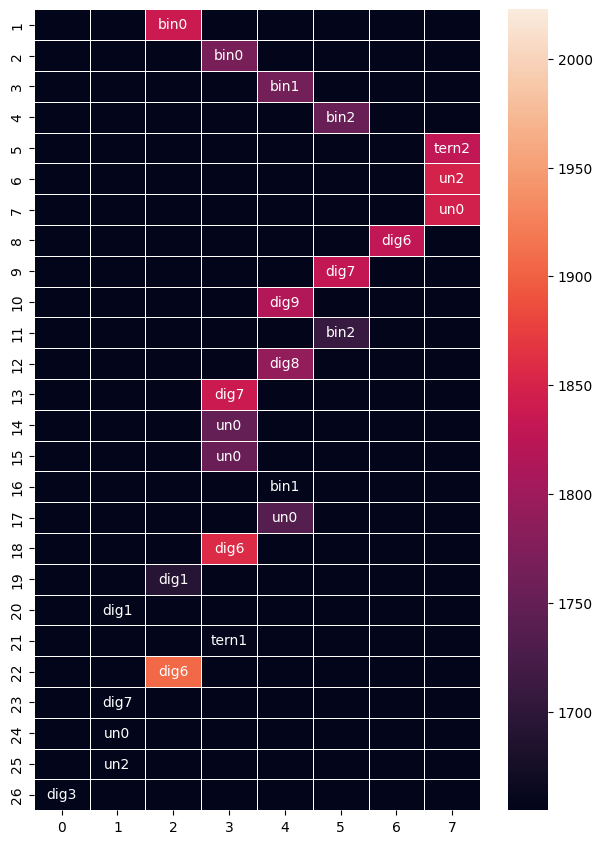

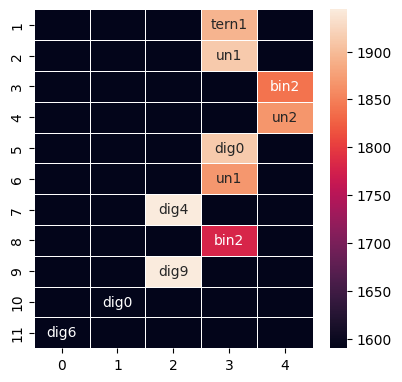

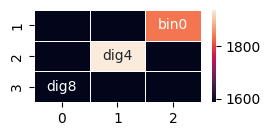

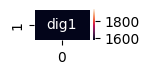

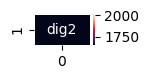

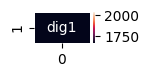

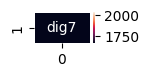

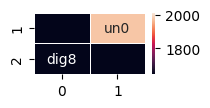

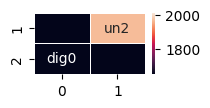

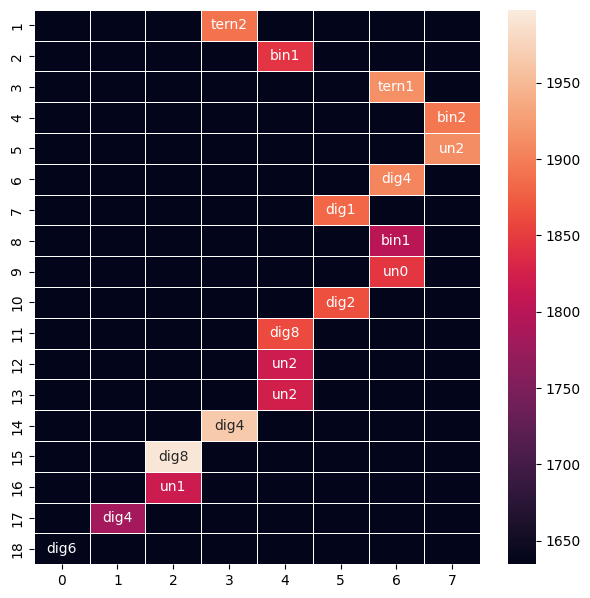

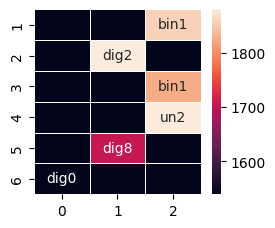

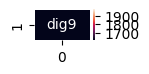

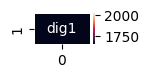

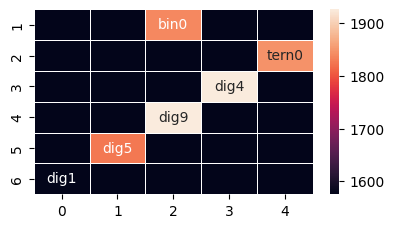

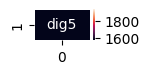

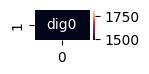

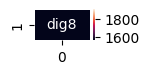

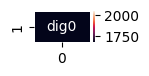

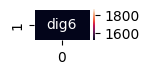

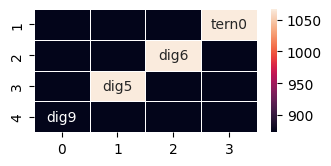

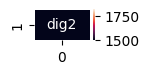

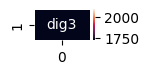

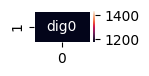

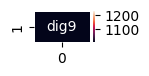

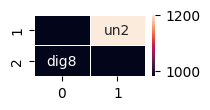

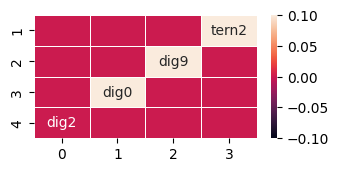

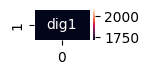

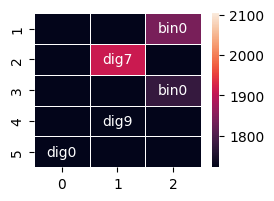

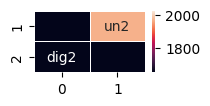

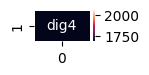

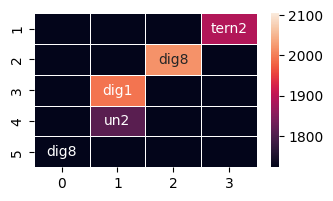

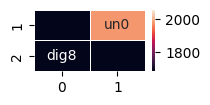

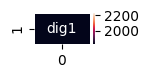

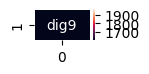

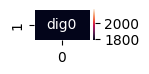

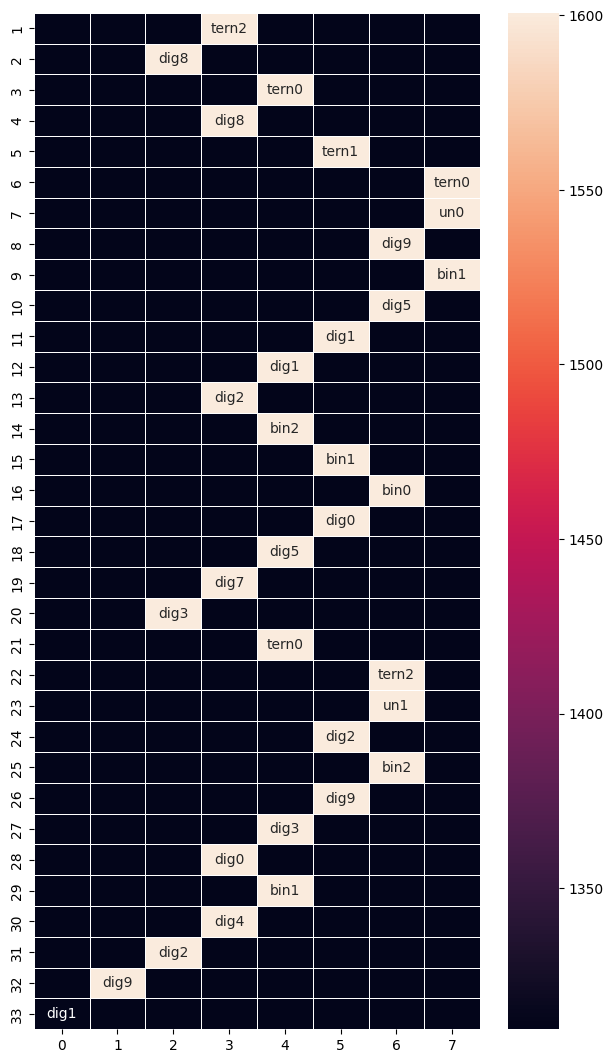

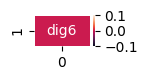

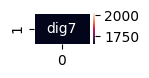

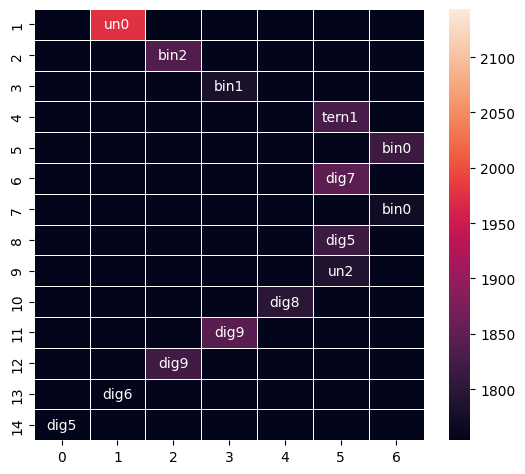

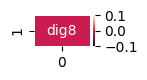

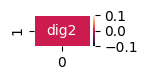

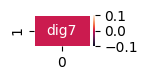

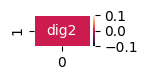

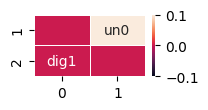

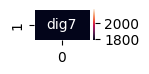

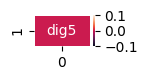

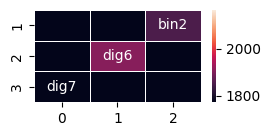

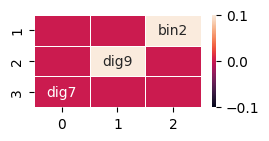

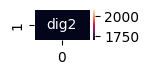

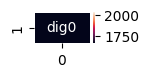

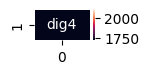

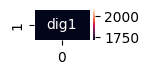

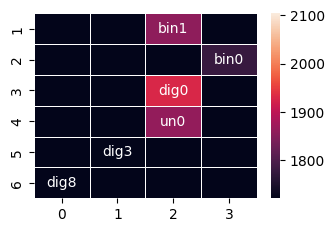

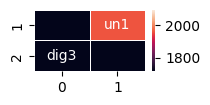

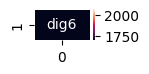

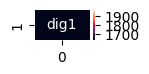

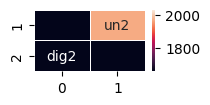

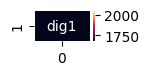

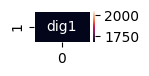

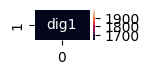

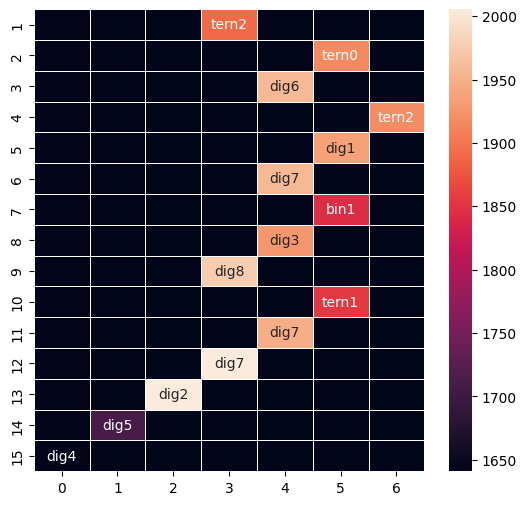

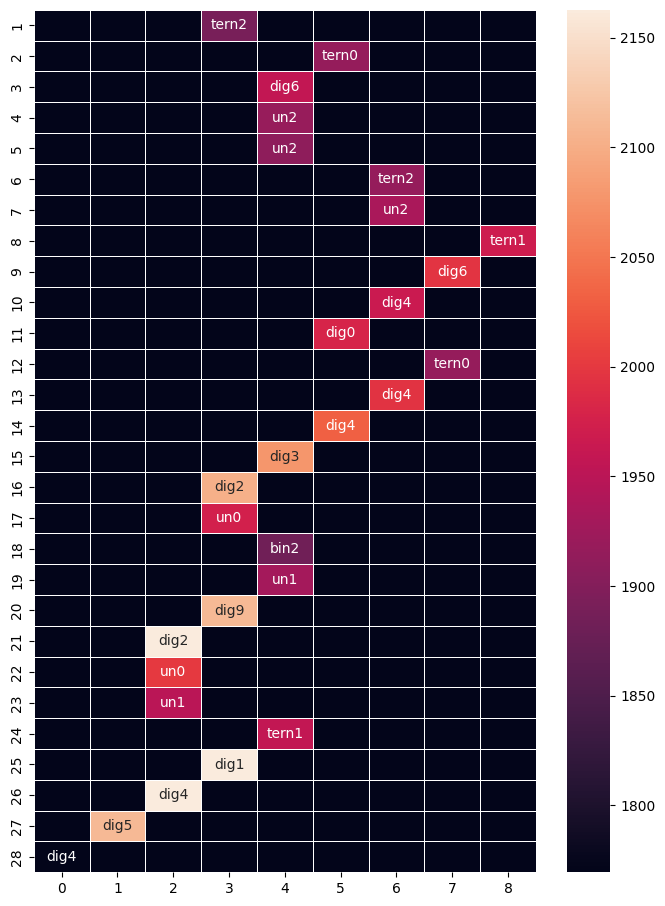

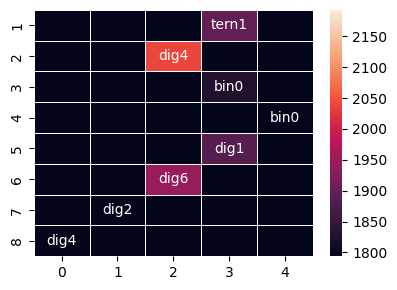

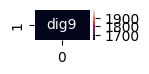

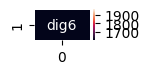

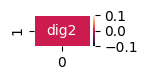

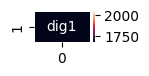

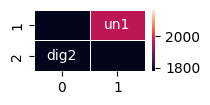

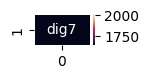

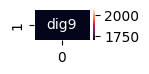

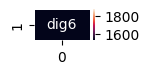

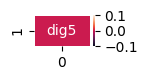

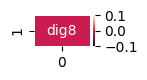

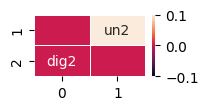

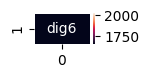

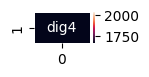

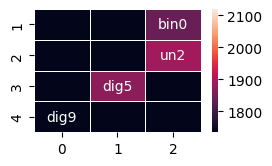

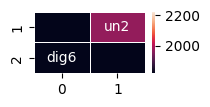

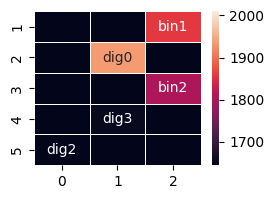

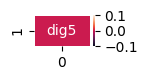

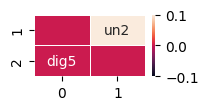

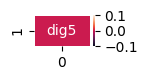

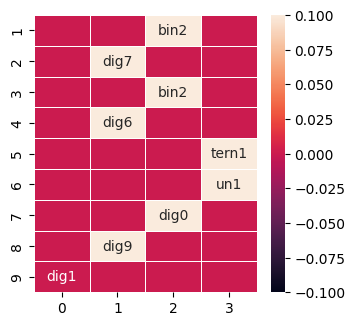

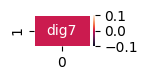

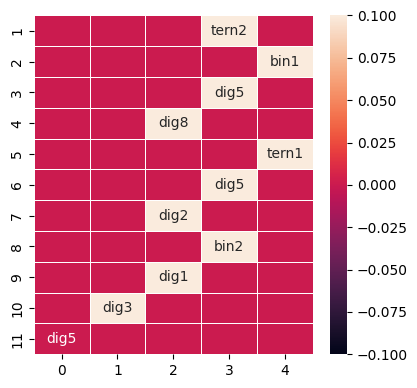

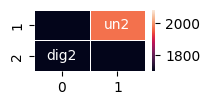

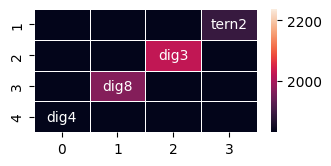

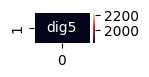

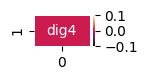

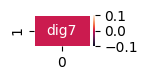

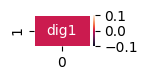

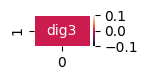

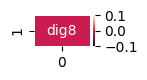

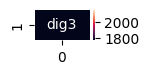

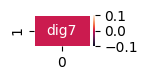

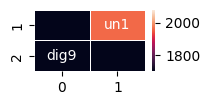

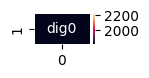

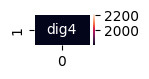

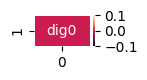

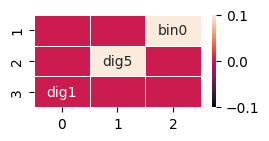

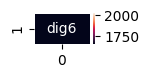

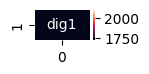

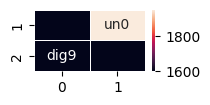

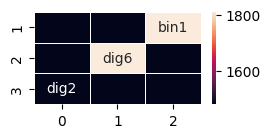

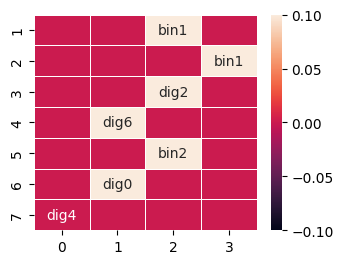

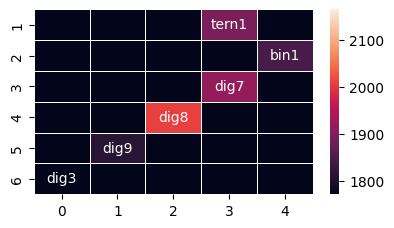

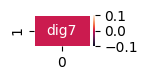

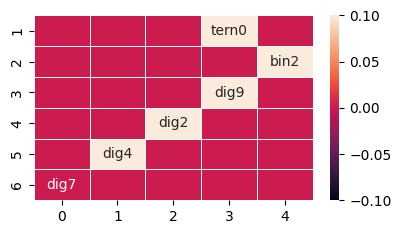

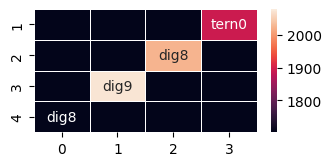

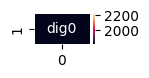

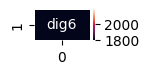

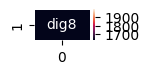

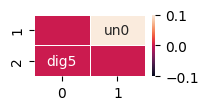

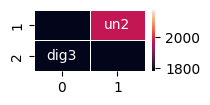

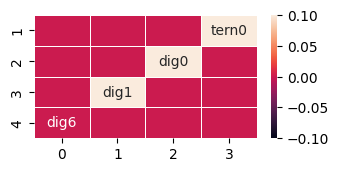

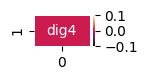

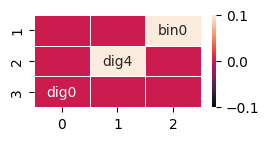

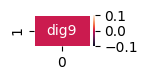

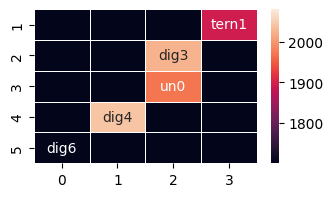

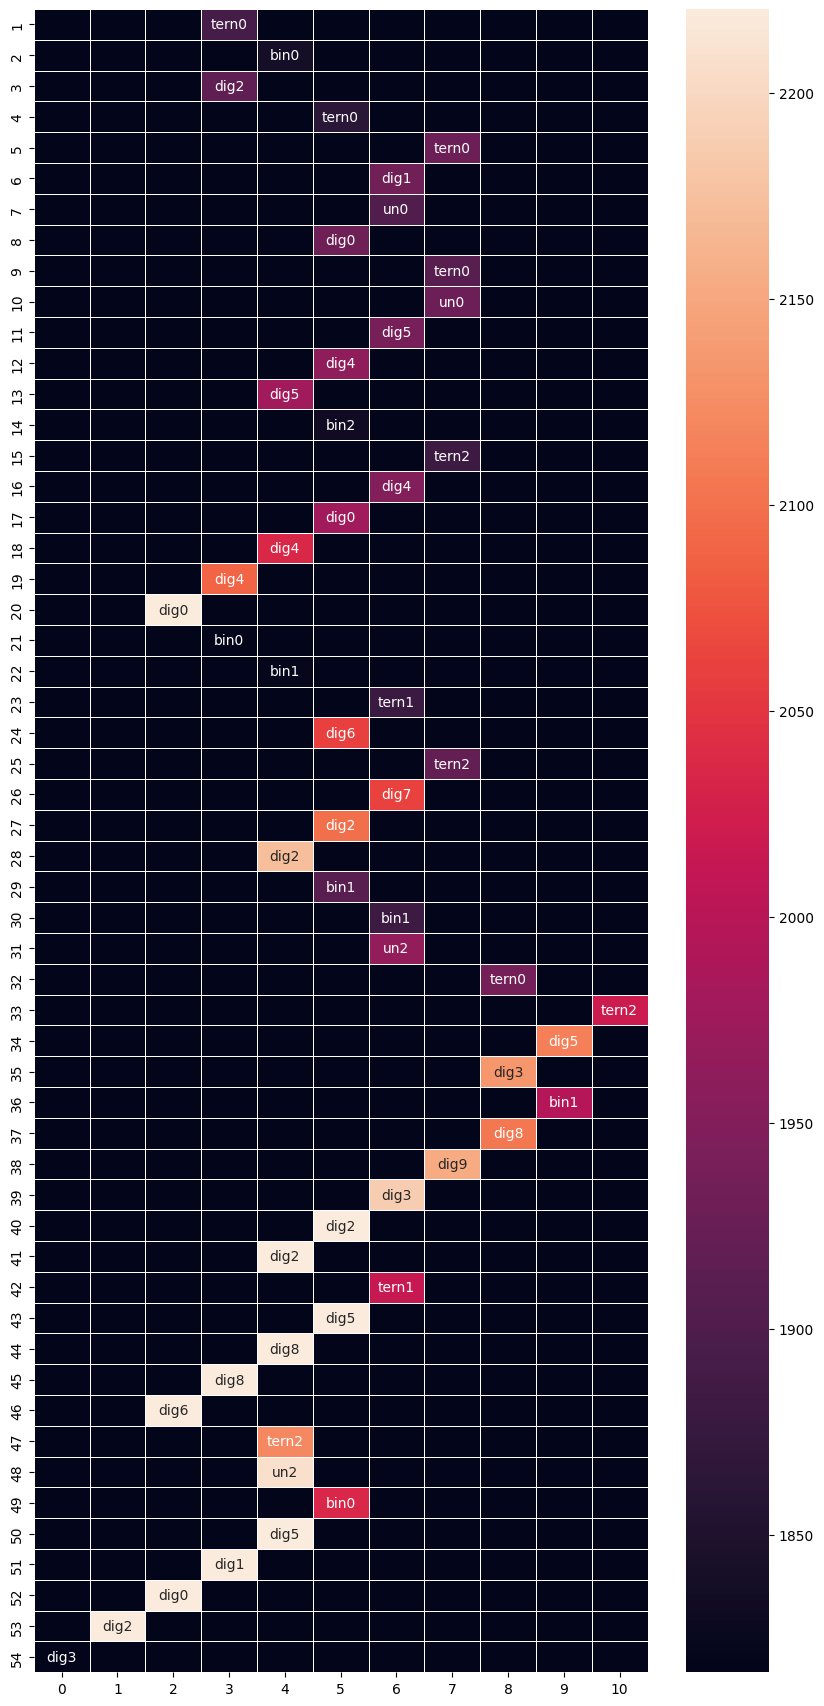

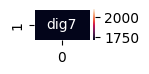

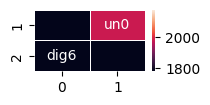

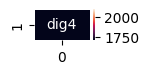

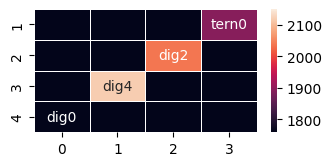

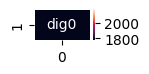

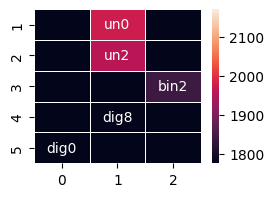

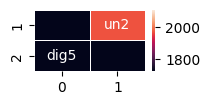

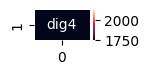

In [12]:
dead = True
while dead:
    fidx = torch.randint(0, latents.size(1), (1,)).item()
    dead = (latents[:, fidx] == 0).all().item()
print(fidx)

vmax = latents[:, fidx].max().item()
vmin = latents[:, fidx].min().item()

for i in range(len(sequences)):
    #plot_latents_linearly(pcfg.detokenize_sentence(sequences[i]).split(), 
    #                      latents_by_sequence[i][:, fidx], vmax, vmin, heatmap=False)
    #plot_latents_by_depth(pcfg.detokenize_sentence(sequences[i]).split(),
    #                      latents_by_sequence[i][:, fidx], pcfg, 
    #                      latents[i, fidx].max().item(),
    #                      latents[i, fidx].min().item())
    #                      #vmax, vmin)
    plot_latents_by_pending(pcfg.detokenize_sentence(sequences[i]).split(),
                            latents_by_sequence[i][:, fidx],
                            latents[i, fidx].max().item(),
                            latents[i, fidx].min().item())
                            #vmax, vmin)


To analyse single sequences.

19


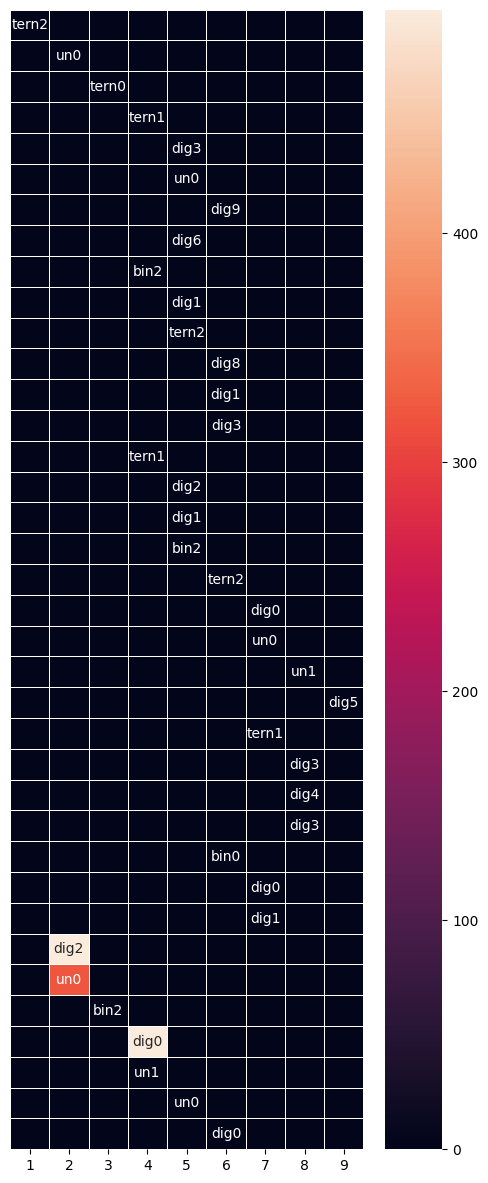

In [124]:
sample = 'tern2 un0 tern0 tern1 dig3 un0 dig9 dig6 bin2 dig1 tern2 dig8 dig1 dig3 tern1 dig2 dig1 bin2 tern2 dig0 un0 un1 dig5 tern1 dig3 dig4 dig3 bin0 dig0 dig1 dig2 un0 bin2 dig0 un1 un0 dig0'#tern2 dig0 dig4 dig6'
tokens = sample.split()
base_sequence = pcfg.tokenize_sentence(sample)

instr = pcfg.tokenize_sentence(dataloader.dataset.instruction_decorator.format(task_token='Task0', ops='<null>'))
sequence = torch.cat((
    torch.tensor(instr),
    torch.tensor(base_sequence),
    torch.tensor([pcfg.vocab['<eos>']])
    ))

activation = 0
def hook(model, input, output):
    global activation
    activation = output
handle = module.register_forward_hook(hook)
logits = model(sequence.unsqueeze(0))
handle.remove()

latents, _ = sae(activation)

token_wise_latents = latents[0, dataloader.dataset.decorator_length:-1, fidx]
print(max(get_depths(tokens, pcfg)))
plot_latents_by_depth(tokens, token_wise_latents, pcfg, vmax, vmin)

We can now check the correlation between the SAE's features and our explanations.

In [14]:
def pending_count(tokens, pcfg):
    """
    Returns, at each token, the number of expressions needed to complete the sequence after it.
    """
    pending = []
    count = 1
    for token in tokens:
        if token[:-1] == 'dig':
            count -= 1
        elif token[:-1] == 'un':
            count += 0
        elif token[:-1] == 'bin':
            count += 1
        elif token[:-1] == 'tern':
            count += 2
        pending.append(count)
    assert pending[-1] == 0
    return pending

In [15]:
def one_expr_pending(tokens, pcfg):
    """
    Returns 1 for a token according to the following algorithm:
    - Find the first binary or ternary operator.
    - Mark the end of its second-last argument and any following unary operators as 1.
    - Repeat this on its last argument.
    This is equivalent to the points of the sentence at which exactly
    one more expression is expected.
    """
    
    pending = pending_count(tokens, pcfg)
    return [0] + [1 if p == 1 else 0 for p in pending[1:]]


In [16]:
def last_token(tokens, pcfg):
    return [0] * (len(tokens) - 1) + [1]

In [17]:
def arity(tokens, pcfg):
    arities = []
    for t in tokens:
        match t[:-1]:
            case 'dig': arities.append(0)
            case 'un': arities.append(1)
            case 'bin': arities.append(2)
            case 'tern': arities.append(3)
    return arities

In [55]:
corrs = []
for fidx in range(latents.size(-1)):
#fidx = 64
    predicted_ft = [[], [], [], []]
    sae_ft = []
    depths = []
    for i in range(len(sequences)):
        tokens = pcfg.detokenize_sentence(sequences[i]).split()

        # Feature n
        predicted_ft = [predicted_ft[0] + pending_count(tokens, pcfg),
                        predicted_ft[1] + one_expr_pending(tokens, pcfg),
                        predicted_ft[2] + last_token(tokens, pcfg),
                        predicted_ft[3] + arity(tokens, pcfg)]

        # SAE Activation
        sae_ft += latents_by_sequence[i][:, fidx].tolist()

        depths += [ceil(d/2)-2 for d in get_depths(tokens, pcfg)]

    ρ = [torch.corrcoef(torch.tensor([p, sae_ft]))[0, 1].item() for p in predicted_ft]
    if not all(math.isnan(r) for r in ρ):
        print(fidx, '\t'.join([f'{r:1.2f}' for r in ρ]))
        corrs.append((fidx, ρ))

# For multi-class/continuous features
# Option 1: Scatterplot with colour-coded depths
#colours = matplotlib.cm.Reds([d/max(depths) for d in depths])
#plt.scatter(predicted_ft, sae_ft, c=colours)
#plt.xlabel('Predicted')
#plt.ylabel('Activation')

# Option 2: Heatmap of average activation per depth-feature pair
#acts = [[[] for _ in range(max(predicted_ft)+1)] for _ in range(max(depths)+1)]
#for i, f in enumerate(predicted_ft):
#    acts[max(depths)-depths[i]][f].append(sae_ft[i])
#means = torch.tensor([[torch.tensor(acts[d][f]).mean().item() for f in range(max(predicted_ft)+1)] for d in range(max(depths)+1)])
#plt.figure(figsize=(10, 7))
#sns.heatmap(means, annot=True, fmt='.2f', linewidths=.5, cmap='Reds', xticklabels=range(max(predicted_ft)+1), yticklabels=range(max(depths), -1, -1))
#plt.xlabel('Count')
#plt.ylabel('Depth')

# For binary features
#plt.violinplot([[sae_ft[i] for i, f in enumerate(predicted_ft) if f == x]
#                for x in range(min(predicted_ft), max(predicted_ft)+1)], positions=range(min(predicted_ft), max(predicted_ft)+1))

plt.show()

16 -0.67	-0.21	0.99	-0.43
24 -0.67	-0.21	1.00	-0.43
57 0.63	0.19	-0.99	0.37
84 -0.67	-0.21	1.00	-0.43
98 -0.66	-0.21	0.98	-0.42
109 -0.67	-0.21	1.00	-0.43
111 -0.66	-0.21	0.98	-0.42
122 0.65	0.16	-0.99	0.40
131 -0.67	-0.21	1.00	-0.43
138 0.65	0.17	-0.99	0.38
146 -0.67	-0.21	0.99	-0.43
151 -0.67	-0.21	0.99	-0.43
152 0.64	0.17	-0.98	0.37
167 0.63	0.19	-0.97	0.36
172 0.66	0.16	-0.99	0.40
181 0.68	0.15	-0.98	0.39
185 0.59	0.20	-0.98	0.36
204 -0.67	-0.21	1.00	-0.43
206 0.62	0.21	-0.98	0.36
214 0.66	0.16	-0.97	0.37
215 0.68	0.15	-0.99	0.40
217 0.57	0.23	-0.97	0.36
219 -0.67	-0.20	0.98	-0.43
223 -0.66	-0.21	0.99	-0.42
229 0.48	0.13	-0.83	0.22
233 0.60	0.20	-0.96	0.41
234 -0.67	-0.20	0.97	-0.44
241 -0.66	-0.21	0.98	-0.42
244 0.68	0.15	-0.99	0.40
248 0.63	0.19	-0.99	0.38
254 -0.66	-0.21	0.98	-0.42


In [56]:
print([len([r[i] for _, r in corrs if abs(r[i]) >= 0.9]) for i in range(4)])
i = torch.argmax(torch.tensor([r[0] for _, r in corrs]))
print(corrs[i][0], corrs[i][1][0])
i = torch.argmax(torch.tensor([r[1] for _, r in corrs]))
print(corrs[i][0], corrs[i][1][1])
i = torch.argmax(torch.tensor([r[2] for _, r in corrs]))
print(corrs[i][0], corrs[i][1][2])
i = torch.argmax(torch.tensor([r[3] for _, r in corrs]))
print(corrs[i][0], corrs[i][1][3])

[0, 0, 30, 0]
244 0.683575451374054
217 0.23036226630210876
204 0.9977447390556335
233 0.40550005435943604
